![data-x](http://oi64.tinypic.com/o858n4.jpg)


# Homework 7: Image Classification with pretrained CNN

#### This HW consists of 5 parts + One Extra Credit question (5p for Part 1-5, 2p for EC)

.



* ## [Part 0: Data-X feedback survey](#sec0)

---

## Part 1-4: Build your own Cats vs Dogs binary classifier

In this HW we will implement a binary Cats vs Dogs classifier by removing the top layer of a pretrained network (VGG16 on Imagenet), extracting the features of the training and validation images and then just training the top layer of that network. This way we will be able to make accurate predictions even though we just have a small data set. This is very similar to the breakout given to you during lecture 7 (found in **module-06** in the Dropbox, folder **Breakout-CNN-CatsVsDogs**).

We want you to able to use the tools that we have presented so far. Therefore, in step 1-4 we want you to install Keras, extract the bottleneck features of your images, train the top layer and lastly make predicitons on images not presented to the CNN so far.

The data conists of 2000 training images (1000 cats and 1000 dogs), 800 validation images (400 cats and 400 dogs), and 100 test images (cats and dogs mixed). Find the data here: https://www.dropbox.com/s/y2suimh2lt5btam/data.zip?dl=1

The pretrained VGG16 weighs that you should load into your model (in order to extract the bottleneck features) can be downloaded here: https://www.dropbox.com/s/o7rxv6y2xf69jmw/vgg16_weights.h5?dl=0


The reason why we are using a pretrained network, extracting bottleneck features and training only the top layers is that this is a great way to obtain a high prediction accuracy without having to run the training for a long time. it would take up to several days to run this analysis and training your own CNN / DNN on a personal computer (in order to obtain the same level of accuracy).

.


* ## [Part 1: Install Keras and Theano (or Tensorflow) + all dependencies](#sec1)

.

* ## [Part 2: Extract bottleneck features from the data set](#sec2)

.

* ## [Part 3: Train the top layer of your CNN](#sec3)

.

* ## [Part 4: Make predicitons on the mixed test images](#sec4)

.

* ## [Extra credit: Train the network on the 50 image classes](#sec5)

___

<a id='sec0'></a>
# Part 0:

We'd love to get your feedback on what you think about the class so far, so as part of the HW please fill out this survey before next lecture: 

# https://goo.gl/forms/ETExtfhymrZJmw3J3

<a id='sec1'></a>

# Part 1: Install Keras + Theano (or Tensorflow)

As a data scientist you will have to be comfortable with installing and setting up your work environment on different systems. Therefore, this first part of the HW will be a valuable lesson on how to troubleshoot if you run into problems. Also, feel free to ask us for guidance either during Office Hours or on Piazza. We are here to help.

If you want you can also try to use Tensorflow as your Keras backend (instead of Theano, that has been shown in class so far). Note that there some syntax and dimension handling differences between these two libraries.

In [1]:
!ls

data
data-x_hw7_image-classificaiton_v2.ipynb
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [2]:
from __future__ import absolute_import, division, print_function
import os
for path, dirs, files in os.walk('./data'):
    print('FOLDER',path)
    for f in files[:4]:
        print(f)

FOLDER ./data
.DS_Store
FOLDER ./data/test
FOLDER ./data/test/catvdog
try001.jpg
try002.jpg
try003.jpg
try004.jpg
FOLDER ./data/train
FOLDER ./data/train/cats
cat0001.jpg
cat0002.jpg
cat0003.jpg
cat0004.jpg
FOLDER ./data/train/dogs
dog0001.jpg
dog0002.jpg
dog0003.jpg
dog0004.jpg
FOLDER ./data/validation
FOLDER ./data/validation/cats
cat001001.jpg
cat001002.jpg
cat001003.jpg
cat001004.jpg
FOLDER ./data/validation/dogs
dog001001.jpg
dog001002.jpg
dog001003.jpg
dog001004.jpg


In [3]:
print('Number of cat training images:', len(next(os.walk('./data/train/cats'))[2]))
print('Number of dog training images:', len(next(os.walk('./data/train/dogs'))[2]))
print('Number of cat validation images:', len(next(os.walk('./data/validation/cats'))[2]))
print('Number of dog validation images:', len(next(os.walk('./data/validation/dogs'))[2]))
print('Number of uncategorized test images:', len(next(os.walk('./data/test/catvdog'))[2]))

Number of cat training images: 1000
Number of dog training images: 1000
Number of cat validation images: 400
Number of dog validation images: 400
Number of uncategorized test images: 100


In [4]:
TRAIN_DIR = './data/train/'
VAL_DIR = './data/validation/'
TEST_DIR = './data/test/' #one mixed category

img_width, img_height = 150, 150

n_train_samples = 2000
n_validation_samples = 800
n_epoch = 30
n_test_samples = 100

In [5]:
!KERAS_BACKEND=theano python -c "from keras import backend"
from keras import backend as K
K.set_image_dim_ordering('tf') # note that we need to have tensorflow dimension ordering still because of the weigths.
print('The backend is:',K.backend())
import tensorflow as tf
print(K.image_dim_ordering()) # should say tf
print(tf.__version__) 

Using Theano backend.


Using TensorFlow backend.


The backend is: tensorflow
tf
1.0.0


In [6]:
import h5py
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import model_from_json
from keras.preprocessing import image

from IPython.display import Image, display

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

<a id='sec2'></a>

# Part 2: Extract bottleneck features from the data set

In the second part you will use the pre-trained VGG network structure (loading in the pretrained VGG16 ImageNET weights). Then you will run your data set through that CNN ones to extract the image features.

A good explanation on how this works (rewritten from source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

#### Using the bottleneck features of a pre-trained network: 90% accuracy in 1 min (GPU) / 10 mins (CPU)

In Part 2 we leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset -- that Kevin showed in Lecture 6. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well (Kevin showed that in Lecture 6). The method presented here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Here's what the VGG16 architecture looks like:

![Image of Yaktocat](https://blog.keras.io/img/imgclf/vgg16_original.png)


**Strategy to extract bottleneck features:** We will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training, validation and test data once, recording the output (the "bottleneck features" from the VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note, therefore we will not use data augmentation.

Store the bottleneck features as .npy files.

In [7]:
def save_bottleneck_features():

    from keras import applications
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height,3))
    
    print('TensorFlow model loaded')

    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
       
        '''This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of image rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)'''

        print('Generate '+name_str+' image features')

        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)
        
        features = model.predict_generator(generator, n_samples)
        np.save('features_'+name_str+'.npy', features) # save bottleneck features to file
    
    generate_features(TEST_DIR, n_test_samples, 'test')
    generate_features(TRAIN_DIR, n_train_samples, 'train')
    generate_features(VAL_DIR, n_validation_samples, 'validation')
    
    print('\nDone! Bottleneck features have been saved')

    
save_bottleneck_features()

TensorFlow model loaded
Generate test image features
Found 100 images belonging to 1 classes.
Generate train image features
Found 2000 images belonging to 2 classes.
Generate validation image features
Found 800 images belonging to 2 classes.

Done! Bottleneck features have been saved


In [8]:
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

val_labels = val_gen.classes

print('\nClassifications:\n',val_gen.class_indices)
print('\nClass labels:\n',val_labels)

Found 800 images belonging to 2 classes.

Classifications:
 {'cats': 0, 'dogs': 1}

Class labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

<a id='sec3'></a>

# Part 3: Train the top layer of your CNN

Ones you have extracted and written the bottleneck features to files, read them in again and use them to train the top layer of your network, i.e. the small fully-connected model on top of the stored features. When you have done this record and answer with your prediciton accuracy.

**Question:** What is the validation accuracy for the last training epoch, and how is it that we can reach such high accuracy with such small amount of data in a short amount of time?

In [10]:
train_data = np.load('features_train.npy')
train_labels = np.array([0] * (n_train_samples // 2) + [1] * (n_train_samples // 2))

validation_data = np.load('features_validation.npy')
# same as val_labels above
validation_labels = np.array([0] * (n_validation_samples // 2) + [1] * (n_validation_samples // 2))

# Add top layers trained ontop of extracted VGG features
# Small fully connected model trained on top of the stored features
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

'''
#We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
#To go with it we will also use the binary_crossentropy loss to train our model.

'''
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels,
          nb_epoch=n_epoch, batch_size=32,
          validation_data=(validation_data, validation_labels)) # fit the model
print('Done!')

Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 4s - loss: 0.8938 - acc: 0.7495 - val_loss: 0.3236 - val_acc: 0.8512

<a id='sec4'></a>

# Part 4: Validate accuracy and make predictions on unlabeled data

**Question:** First use the model trained in Part 3 to determine the accuracy on the validation data set (is it the same as one the last training epoch?

Lastly, use the model trained in Part 3 to classify the test data images. I.e., create a function that loads one image from the test data and then predicts if it is a cat or a dog and with what probability it thinks it is a cat or a dog

In [11]:
val_pred_class = model.predict_classes(validation_data,verbose=0)
val_pred_prob = model.predict_proba(validation_data,verbose=0)
print('Accuracy on validation set: ',
(val_pred_class.ravel()==val_labels).sum()/800.*100,'%')

Accuracy on validation set:  90.625 %


In [12]:
print(model.evaluate(validation_data,val_labels,verbose=0))
# First number is validation loss, loss of the objective function
# Second number validation accuracy

[0.65106527626514432, 0.90625]


In [13]:

test_data = np.load('features_test.npy')

test_images =  [TEST_DIR+'catvdog/'+img for img in os.listdir(TEST_DIR+'catvdog/')]



test_datagen = ImageDataGenerator(rescale=1. / 255)

def read_image(file_path):
    # For image visualization
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_CUBIC)

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()



This is a CAT with 99.99586% probability


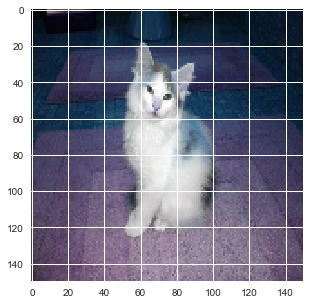



This is a DOG with 99.72731% probability


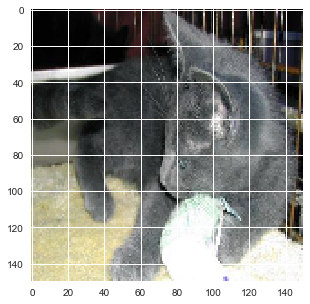



This is a DOG with 100.0% probability


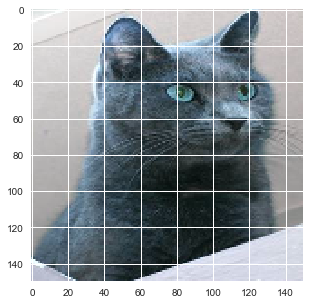



This is a DOG with 83.44552% probability


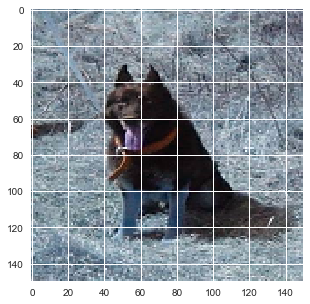



This is a CAT with 50.12578% probability


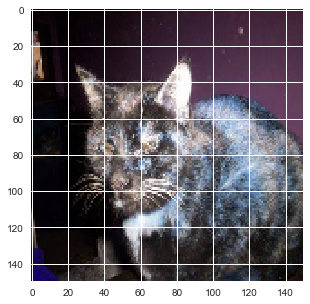



This is a DOG with 75.79154% probability


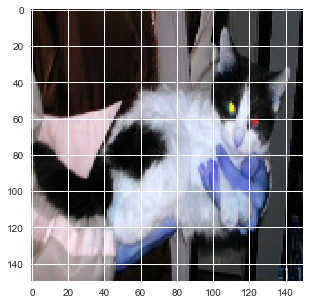



This is a CAT with 60.00416% probability


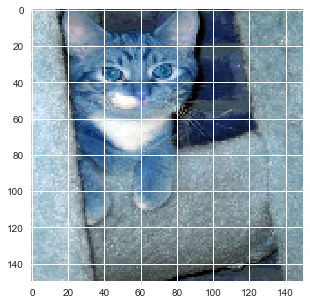



This is a CAT with 51.63606% probability


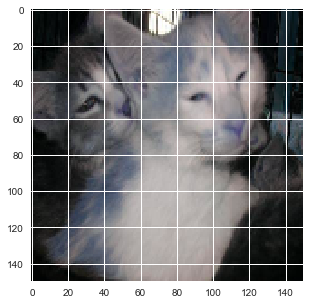



This is a CAT with 99.81133% probability


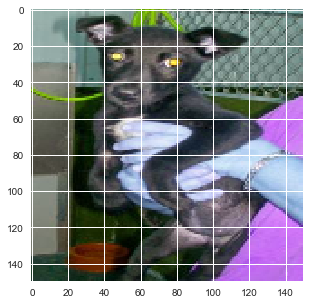

In [14]:
def predict(mod,i=0,r=None):
    
    if r==None:
        r=[i]
        
    for idx in r:
        class_pred = mod.predict_classes(test_data,verbose=0)[idx]
        prob_pred = mod.predict_proba(test_data,verbose=0)[idx]
        
        if class_pred ==0:
            prob_pred = 1-prob_pred
            class_guess='CAT'
        else:
            class_guess='DOG'
        
        print('\n\nThis is a ' + class_guess + ' with ' +str(round(float(prob_pred)*100,5)) + '% probability')
        plot_pic(test_images[idx])

test_data = test_data.T.reshape((2500, 512, 4, 4))
predict(model,r=range(1,10))

<a id='sec5'></a>

# Extra credit

Redo the model and pipeline created in Part 1-4 in order to make predictions on the 50 image classes (shown to you during lecture 6). Note that you might have to change how you read in the images, so that when you train the model you do a cross validation split (25 / 75) instead of specifying a specific validation set.  And, you will want to use a `softmax` activation layer instead of a `sigmoid` one (to do multiclass classification).

The data can be downloaded here: https://www.dropbox.com/s/suy8u0hnthwr2su/50_categories.tar.gz?dl=1

Note that you do not have to additional data to make predictions on data not used in the training (however you can easily download 3-5 images like that from Google to try your model).